# Anaylsis and Conclusions

Okay now we've moved a ton of data around, we've done layers and layers and layers of transformations. We've looked at distributions, and nulls, and distincts. We've painstakinlgy review model and hpyerparmater options. Now, let's look at our data! If you're running the full scripts you need to execute scripts 9-11 to get all content for your model versions. If you're not executing the scripts, sufficient sample data for all aggregations and visualizations below is already in the data folder and you're good to go.

Now let's see how our pipeline did!

#### Import statements

In [43]:
from IPython.display import Image
from IPython.display import display
import numpy as np
import pandas as pd

## Final clustering output and segment data

The dataset we will be looking at contains all of the cluster outputs joined with information from the orignal segments. We will be doing a lot of visualizations, so we will be focusing on the trajectory data.

Some notes on thow the trajectory data was tranformed:
- for this analysis we are looking at flight patterns, not any absolute flight locations
- all of the has been transformed to start at X, Y values of 0, 0
- all of the traces have been rotated to be oriented in the same direction, at the beginning of the trace
- the original x and y values of the traces is also in the dataframe
- all of this data can be joined with the orignal flight data
  - to do so, the segment_ids can be joined to the autoencoder_training_unscaled data, which will give you the icao and the start_timestamps
  - the first start_timestamp can be used to combine the data with the the orignal trace data

In [ ]:
# read in and examine trajectories
trajectories = pd.read_parquet('../data/_11_analysis_&_conclusions/trajectories.parquet')

display(trajectories)

,segment_id,cluster,is_most_typical,is_most_extreme,icao,start_timestamp,point_idx,x,y,z,heading_deg,ground_speed,time_sec,original_x,original_y
0,11523328,-1,False,False,ab3d9a,2024-08-01 21:23:58.860000+00:00,0,0.000000e+00,0.000000e+00,19200.0,316.40,394.70,0.00,0.00,0.00
1,11523328,-1,False,False,ab3d9a,2024-08-01 21:23:58.860000+00:00,1,3.720587e+01,5.492236e+03,19525.0,316.80,394.00,13.94,-3759.78,4003.76
2,11523328,-1,False,False,ab3d9a,2024-08-01 21:23:58.860000+00:00,2,3.472619e+01,1.745698e+04,19775.0,316.40,397.50,30.10,-12010.90,12668.29
3,11523328,-1,False,False,ab3d9a,2024-08-01 21:23:58.860000+00:00,3,7.503692e-13,3.524056e+04,20050.0,316.30,398.20,44.66,-24297.29,25525.26
4,11523328,-1,False,False,ab3d9a,2024-08-01 21:23:58.860000+00:00,4,-3.142208e+02,6.052945e+04,20275.0,315.70,402.40,62.85,-41960.80,43625.73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1159395,12013506,2,False,False,c03197,2024-08-01 00:15:56.530000+00:00,45,1.296399e+06,1.204487e+06,13875.0,278.80,242.80,309.21,-1208354.96,-1292794.19
1159396,12013506,2,False,False,c03197,2024-08-01 00:15:56.530000+00:00,46,1.370067e+06,1.183170e+06,13750.0,282.10,243.40,315.08,-1283341.61,-1276718.44
1159397,12013506,2,False,False,c03197,2024-08-01 00:15:56.530000+00:00,47,1.445585e+06,1.163164e+06,13675.0,280.80,245.40,318.35,-1360080.93,-1262079.64
1159398,12013506,2,False,False,c03197,2024-08-01 00:15:56.530000+00:00,48,1.523643e+06,1.146660e+06,13475.0,277.90,246.40,323.80,-1439108.05,-1251113.72


In [ ]:
# Spatial statistics (x, y, z coordinates)
spatial_stats = trajectories.groupby('cluster').agg({
    'x': ['mean', 'std', 'min', 'max'],
    'y': ['mean', 'std', 'min', 'max'],
    'z': ['mean', 'std', 'min', 'max']
}).round(2)

# Flatten column names
spatial_stats.columns = ['_'.join(col).strip() for col in spatial_stats.columns.values]
spatial_stats = spatial_stats.reset_index()

# Motion characteristics (heading, speed, time)
motion_stats = trajectories.groupby('cluster').agg({
    'heading_deg': ['mean', 'std', 'min', 'max'],
    'ground_speed': ['mean', 'std', 'min', 'max'],
    'time_sec': ['mean', 'std', 'min', 'max']
}).round(2)

# Flatten column names
motion_stats.columns = ['_'.join(col).strip() for col in motion_stats.columns.values]
motion_stats = motion_stats.reset_index()

# Add trajectory length to motion stats
motion_stats['points_count'] = trajectories.groupby('cluster').size()

print("Spatial Statistics:")
display(spatial_stats)
print("\nMotion Statistics:")
display(motion_stats)

Spatial Statistics:


,cluster,x_mean,x_std,x_min,x_max,y_mean,y_std,y_min,y_max,z_mean,z_std,z_min,z_max
0,-1,-5941.74,511128.64,-6898865.68,9208323.91,1662372.42,2125981.62,-3994614.20,15253463.94,19636.26,13409.69,-525.0,57100.0
1,0,-18969.32,299599.76,-4453223.99,2760629.42,899781.99,1010419.98,0.00,8841375.46,7245.20,5963.63,375.0,38050.0
2,1,-72586.59,803735.62,-4990210.83,4306519.52,2411484.08,2207708.95,0.00,9346566.47,31523.86,5827.66,11725.0,52400.0
3,2,281.42,335535.88,-5439215.79,5364853.83,642679.67,927729.35,-3327518.42,8225827.02,9063.77,9071.60,-500.0,58100.0
4,3,-24994.98,183299.62,-2761139.59,1088544.38,696428.50,714944.81,0.00,6716539.63,6140.14,5121.14,600.0,49825.0
5,4,3031.87,219271.36,-2421209.13,2976610.20,3735462.14,3371652.21,0.00,14640869.32,36393.61,3308.51,15175.0,49025.0
6,5,3132.38,28770.87,-639314.19,428773.07,1428979.05,1386950.36,0.00,9696991.91,11301.72,6223.34,2600.0,33000.0



Motion Statistics:


,cluster,heading_deg_mean,heading_deg_std,heading_deg_min,heading_deg_max,ground_speed_mean,ground_speed_std,ground_speed_min,ground_speed_max,time_sec_mean,time_sec_std,time_sec_min,time_sec_max,points_count
0,-1,180.541634,107.32,0.00,360.00,304.331299,148.44,0.20,1030.60,316.590178,230.04,0.00,2016.05,5850.0
1,0,205.092274,116.51,0.00,359.50,147.768137,72.35,0.70,492.50,360.631997,213.70,0.00,851.74,6750.0
2,1,210.616089,89.01,1.50,354.20,451.825556,57.14,10.10,581.10,327.413956,199.90,0.00,796.61,274600.0
3,2,173.033257,97.95,0.00,359.90,198.45047,123.71,0.70,790.70,203.650336,141.71,0.00,1165.49,5900.0
4,3,197.517322,102.90,0.00,359.50,126.927712,44.89,1.20,481.90,327.831875,197.04,0.00,800.93,151700.0
5,4,188.129679,98.26,0.00,359.90,461.696548,47.65,146.00,629.40,474.940178,278.29,0.00,1309.64,18950.0
6,5,178.961726,94.74,2.00,359.40,175.064121,48.88,71.50,406.20,478.894742,281.01,0.00,1409.07,NaN


In [33]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio

# Get the first segment_id
first_segment = trajectories['segment_id'].unique()[0]

# Filter data for first segment
segment_data = trajectories[trajectories['segment_id'] == first_segment]

# Create the 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=segment_data['x'],
    y=segment_data['y'],
    z=segment_data['z'],
    mode='lines+markers',
    line=dict(
        width=2,
        color='blue'
    ),
    marker=dict(
        size=2,
        color='blue',
        opacity=0.8  # Added some transparency
    )
)])

# Update layout for better visualization
fig.update_layout(
    title=f'Flight Path - Segment {first_segment}',
    scene=dict(
        camera=dict(
            up=dict(x=0, y=0, z=1),
            center=dict(x=0, y=0, z=0),
            eye=dict(x=1.5, y=1.5, z=1.5)  # Adjusted camera position
        ),
        aspectmode='cube',  # Forces a cubic aspect ratio
        xaxis=dict(
            title='X',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        yaxis=dict(
            title='Y',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        zaxis=dict(
            title='Z',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        )
    ),
    width=1000,
    height=800
)

# Display interactive plot
fig.show()

# Save static version for GitHub
pio.write_image(fig, "flight_path.png")

# Optional: Print the range of values for each axis to check scale
print(f"X range: {segment_data['x'].min():.2f} to {segment_data['x'].max():.2f}")
print(f"Y range: {segment_data['y'].min():.2f} to {segment_data['y'].max():.2f}")
print(f"Z range: {segment_data['z'].min():.2f} to {segment_data['z'].max():.2f}")

X range: -838811.50 to 353688.21
Y range: 0.00 to 7834685.21
Z range: 19200.00 to 26000.00


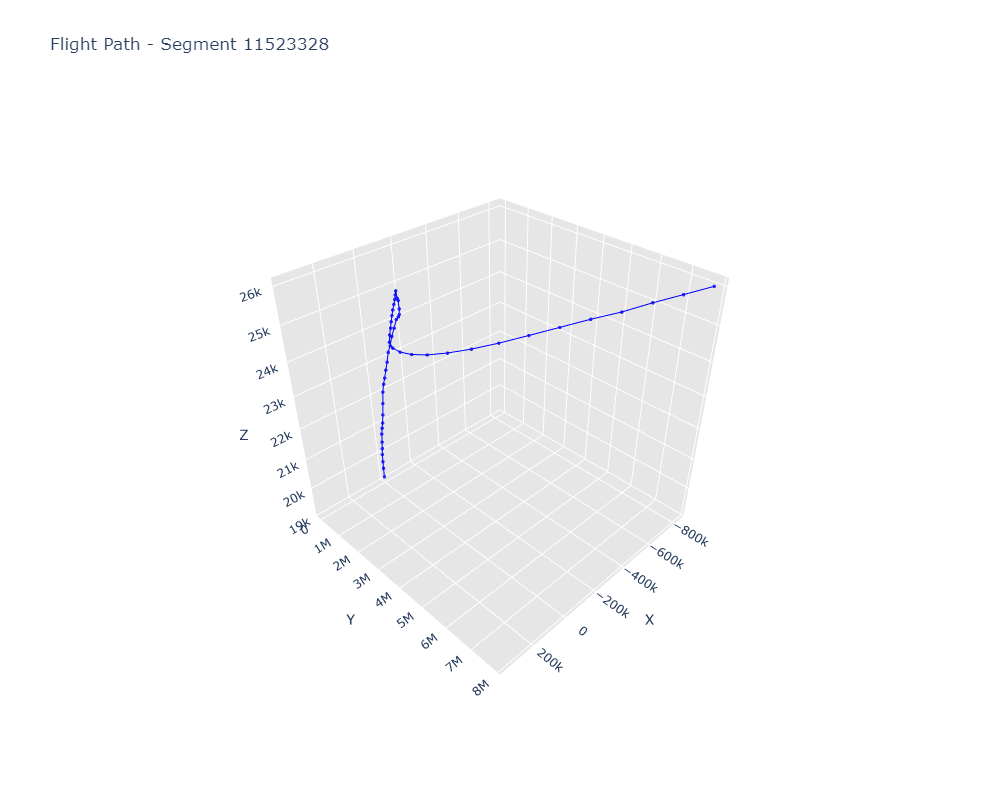

In [34]:
Image("flight_path.png")

In [35]:
import pandas as pd
import plotly.graph_objects as go
import numpy as np
import random
import plotly.express as px  # for the color sequence

# Filter for cluster 1
cluster_data = trajectories[trajectories['cluster'] == 1]

# Convert decimal columns to float if needed
numeric_columns = ['x', 'y', 'z']
for col in numeric_columns:
    if cluster_data[col].dtype == 'object':
        cluster_data[col] = cluster_data[col].astype(float)

# Get unique segment IDs for cluster 1
unique_segments = cluster_data['segment_id'].unique()

# Get random sample of up to 50 segment IDs
n_segments = min(50, len(unique_segments))
selected_segments = np.random.choice(unique_segments, size=n_segments, replace=False)

# Calculate overall ranges for consistent scaling
x_min, x_max = cluster_data['x'].min(), cluster_data['x'].max()
y_min, y_max = cluster_data['y'].min(), cluster_data['y'].max()
z_min, z_max = cluster_data['z'].min(), cluster_data['z'].max()
max_range = max(x_max - x_min, y_max - y_min, z_max - z_min)

# Create a color sequence
colors = px.colors.qualitative.Set3  # Using Set3 palette which has good visibility for multiple traces
# If we need more colors than available in the palette, we'll cycle through them
colors = colors * (n_segments // len(colors) + 1)

# Create the 3D scatter plot
fig = go.Figure()

# Add each trajectory as a separate trace
for idx, segment_id in enumerate(selected_segments):
    segment_data = cluster_data[cluster_data['segment_id'] == segment_id]
    
    fig.add_trace(go.Scatter3d(
        x=segment_data['x'],
        y=segment_data['y'],
        z=segment_data['z'],
        mode='lines',
        line=dict(
            width=2,
            color=colors[idx]
        ),
        opacity=0.8,  # Increased opacity a bit since we have different colors
        name=f'Segment {segment_id}'
    ))

# Update layout for better visualization
fig.update_layout(
    title=f'Flight Paths - Cluster 1 (Random {n_segments} Segments)',
    scene=dict(
        camera=dict(
            up=dict(x=0, y=0, z=1),
            center=dict(x=0, y=0, z=0),
            eye=dict(x=1.5, y=1.5, z=1.5)
        ),
        aspectmode='cube',
        xaxis=dict(
            title='X',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)',
            range=[float(x_min - max_range*0.1), float(x_max + max_range*0.1)]
        ),
        yaxis=dict(
            title='Y',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)',
            range=[float(y_min - max_range*0.1), float(y_max + max_range*0.1)]
        ),
        zaxis=dict(
            title='Z',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)',
            range=[float(z_min - max_range*0.1), float(z_max + max_range*0.1)]
        )
    ),
    width=1000,
    height=800,
    showlegend=True
)

# Display interactive plot
fig.show()

# Save static version
pio.write_image(fig, "cluster1_paths_colored.png")

print(f"Total number of segments in cluster 1: {len(unique_segments)}")
print(f"Number of segments plotted: {n_segments}")

Total number of segments in cluster 1: 135
Number of segments plotted: 50


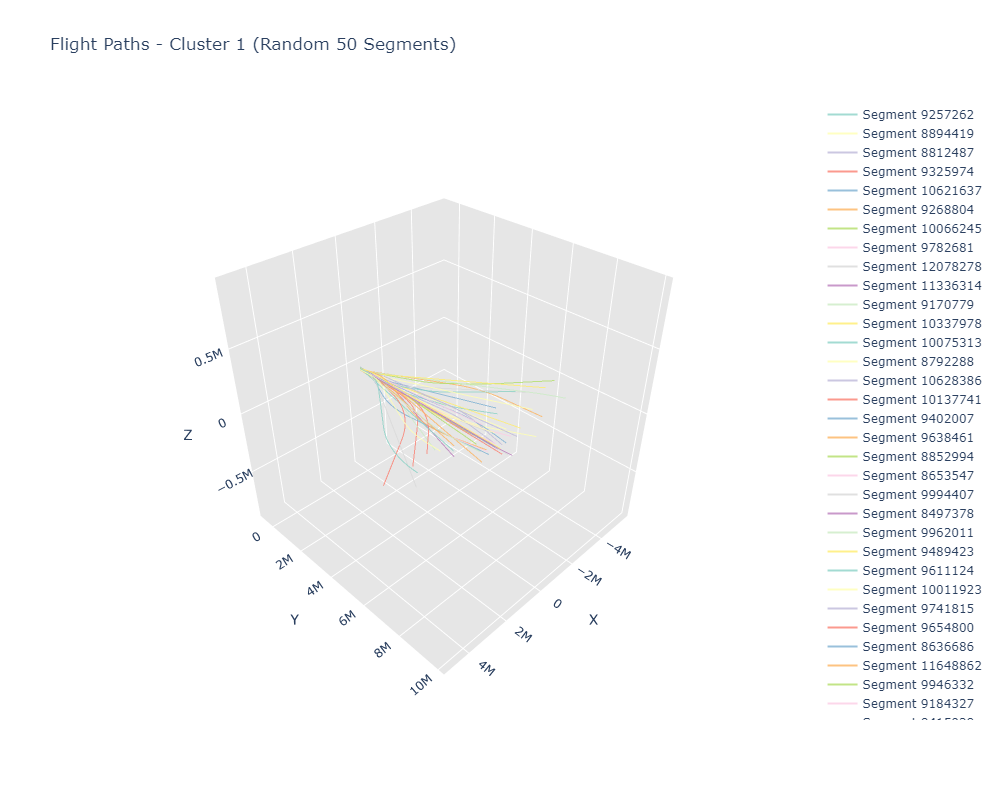

In [36]:
Image("cluster1_paths_colored.png")

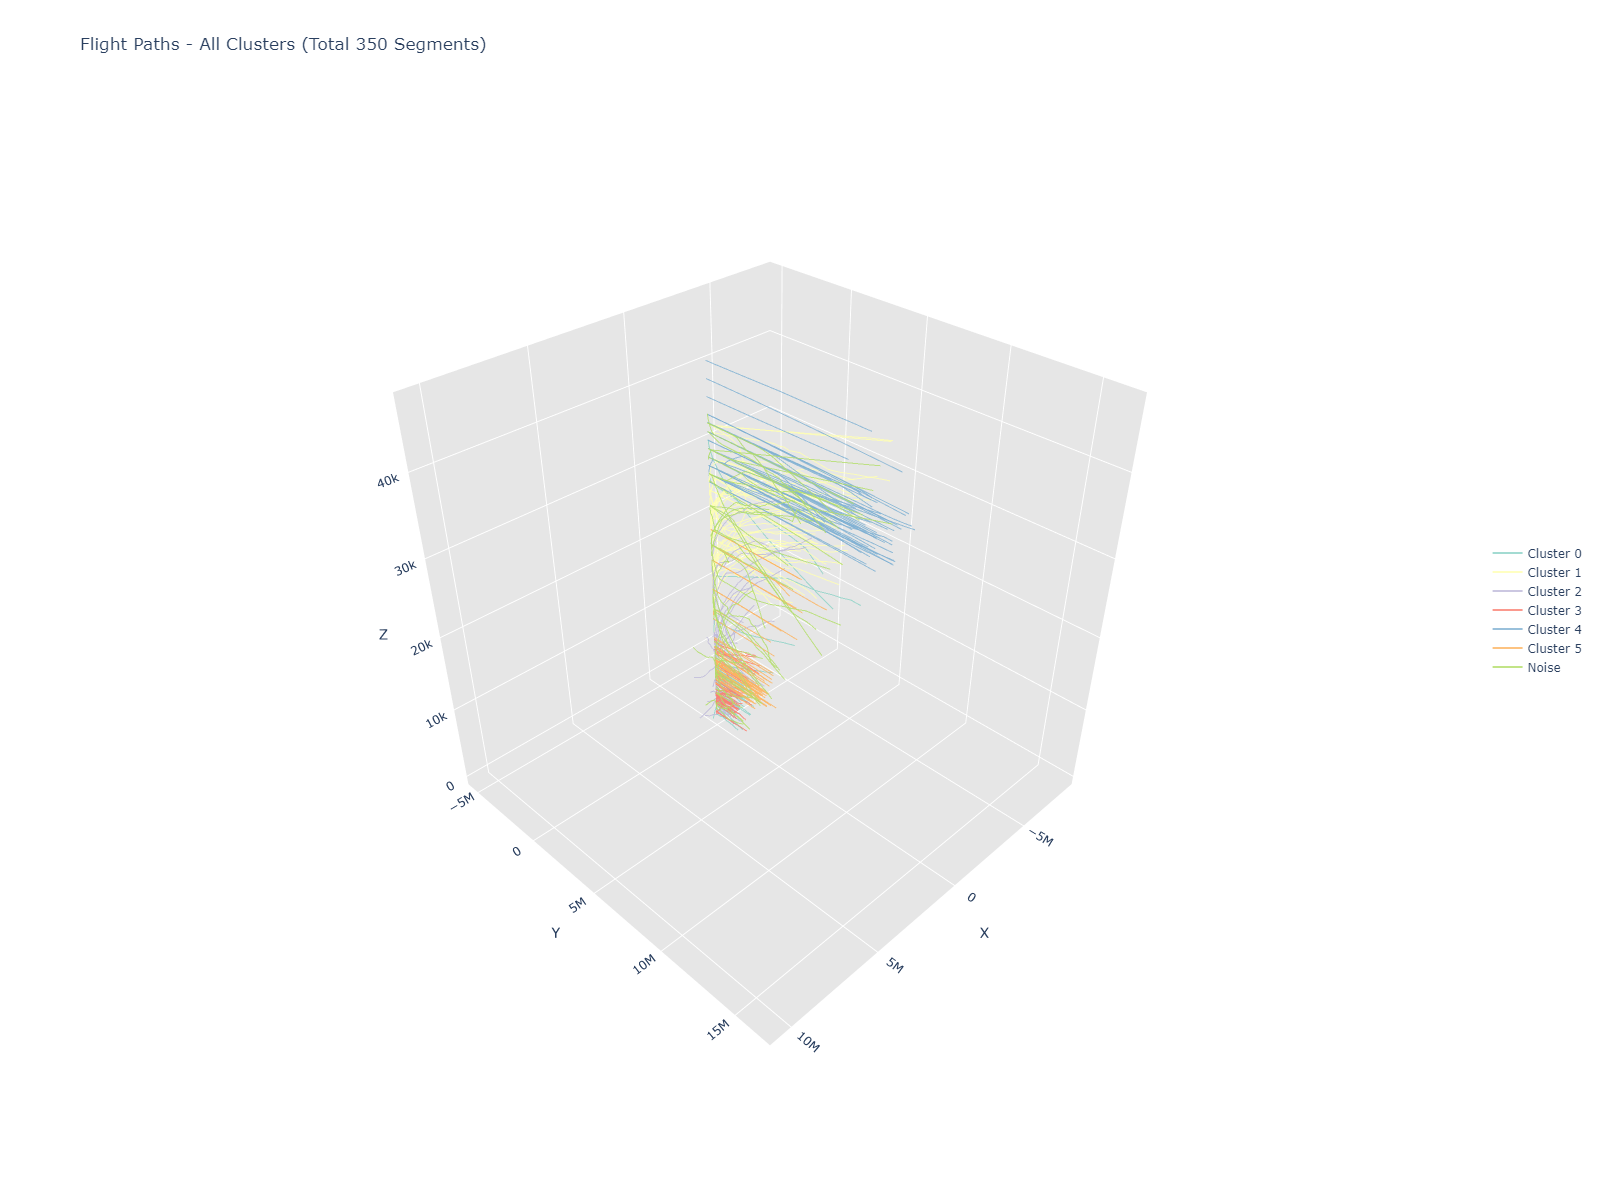

In [37]:
import pandas as pd
import plotly.graph_objects as go
import numpy as np
import random
import plotly.express as px
import plotly.io as pio

# Get all unique clusters and sort them so -1 is last
all_clusters = sorted(trajectories['cluster'].unique())
if -1 in all_clusters:
    all_clusters.remove(-1)
    all_clusters.append(-1)

# Create the 3D scatter plot
fig = go.Figure()

# Calculate overall ranges for consistent scaling across all clusters
x_min, x_max = trajectories['x'].min(), trajectories['x'].max()
y_min, y_max = trajectories['y'].min(), trajectories['y'].max()
z_min, z_max = trajectories['z'].min(), trajectories['z'].max()
max_range = max(x_max - x_min, y_max - y_min, z_max - z_min)

# Create a color sequence for each cluster
cluster_colors = px.colors.qualitative.Set3
# If we need more colors than available in the palette, we'll cycle through them
cluster_colors = cluster_colors * (len(all_clusters) // len(cluster_colors) + 1)

# Track total segments for title
total_segments = 0

# Process each cluster
for cluster_idx, cluster in enumerate(all_clusters):
    # Filter for current cluster
    cluster_data = trajectories[trajectories['cluster'] == cluster]
    
    # Convert decimal columns to float if needed
    numeric_columns = ['x', 'y', 'z']
    for col in numeric_columns:
        if cluster_data[col].dtype == 'object':
            cluster_data[col] = cluster_data[col].astype(float)
    
    # Get unique segment IDs for current cluster
    unique_segments = cluster_data['segment_id'].unique()
    
    # Get random sample of up to 50 segment IDs
    n_segments = min(50, len(unique_segments))
    selected_segments = np.random.choice(unique_segments, size=n_segments, replace=False)
    total_segments += n_segments
    
    cluster_name = 'Noise' if cluster == -1 else f'Cluster {cluster}'
    
    # Add each trajectory as a separate trace
    for idx, segment_id in enumerate(selected_segments):
        segment_data = cluster_data[cluster_data['segment_id'] == segment_id]
        
        fig.add_trace(go.Scatter3d(
            x=segment_data['x'],
            y=segment_data['y'],
            z=segment_data['z'],
            mode='lines',
            line=dict(
                width=2,
                color=cluster_colors[cluster_idx]
            ),
            opacity=0.8,
            name=cluster_name,
            showlegend=(idx == 0)  # Only show legend entry once per cluster
        ))

# Update layout for better visualization
fig.update_layout(
    title=f'Flight Paths - All Clusters (Total {total_segments} Segments)',
        scene=dict(
        camera=dict(
            up=dict(x=0, y=0, z=1),
            center=dict(x=0, y=0, z=0),
            eye=dict(x=1.5, y=1.5, z=1.5)
        ),
        aspectmode='manual',  # Changed from 'cube' to 'manual'
        aspectratio=dict(x=1, y=1),  # Forces X and Y to be equal scale
        xaxis=dict(
            title='X',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)',
            range=[float(x_min - max_range*0.1), float(x_max + max_range*0.1)]
        ),
        yaxis=dict(
            title='Y',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)',
            range=[float(y_min - max_range*0.1), float(y_max + max_range*0.1)]
        ),
        zaxis=dict(
            title='Z',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)',
        )
    ),
    width=1600,
    height=1200,
    showlegend=True,
    legend=dict(yanchor="middle", y=0.5)
)

# Display interactive plot
fig.show()

# Save static version
pio.write_image(fig, "all_clusters_paths.png")

Image("all_clusters_paths.png")

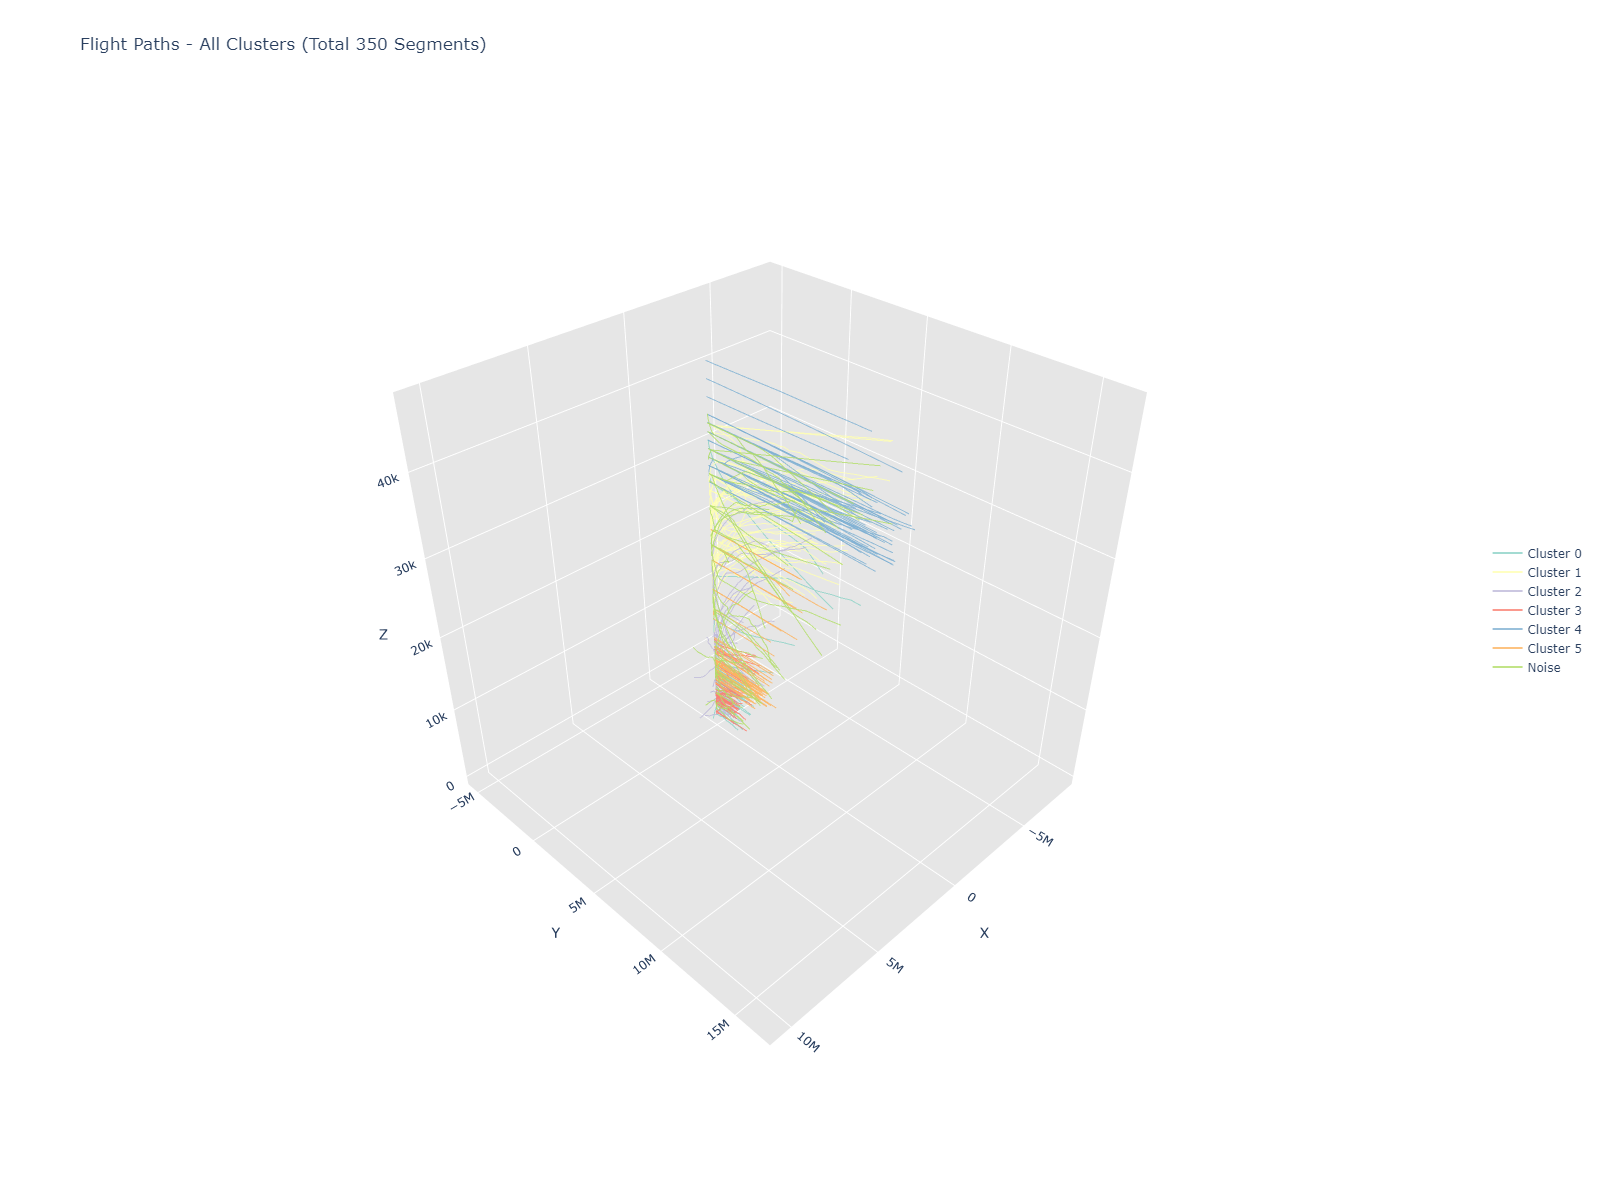

In [38]:
Image("all_clusters_paths.png")

In [39]:
import pandas as pd
import plotly.graph_objects as go
import numpy as np
import random
import plotly.express as px
import plotly.io as pio

# Get all unique clusters and sort them so -1 is last
all_clusters = sorted(trajectories['cluster'].unique())
if -1 in all_clusters:
    all_clusters.remove(-1)
    all_clusters.append(-1)

# Calculate overall ranges for consistent scaling across all plots
x_min, x_max = trajectories['x'].min(), trajectories['x'].max()
y_min, y_max = trajectories['y'].min(), trajectories['y'].max()
z_min, z_max = trajectories['z'].min(), trajectories['z'].max()
max_range = max(x_max - x_min, y_max - y_min, z_max - z_min)

# Process each cluster
for cluster in all_clusters:
    # Create a new figure for each cluster
    fig = go.Figure()
    
    # Filter for current cluster
    cluster_data = trajectories[trajectories['cluster'] == cluster]
    
    # Convert decimal columns to float if needed
    numeric_columns = ['x', 'y', 'z']
    for col in numeric_columns:
        if cluster_data[col].dtype == 'object':
            cluster_data[col] = cluster_data[col].astype(float)
    
    # Get unique segment IDs for current cluster
    unique_segments = cluster_data['segment_id'].unique()
    
    # Get random sample of up to 50 segment IDs
    n_segments = min(50, len(unique_segments))
    selected_segments = np.random.choice(unique_segments, size=n_segments, replace=False)
    
    # Create a color sequence
    colors = px.colors.qualitative.Set3
    colors = colors * (n_segments // len(colors) + 1)
    
    # Add each trajectory as a separate trace
    for idx, segment_id in enumerate(selected_segments):
        segment_data = cluster_data[cluster_data['segment_id'] == segment_id]
        
        fig.add_trace(go.Scatter3d(
            x=segment_data['x'],
            y=segment_data['y'],
            z=segment_data['z'],
            mode='lines',
            line=dict(
                width=2,
                color=colors[idx]
            ),
            opacity=0.8,
            name=f'Segment {segment_id}'
        ))
    
    # Update layout for better visualization
    cluster_name = 'Noise' if cluster == -1 else f'Cluster {cluster}'
    fig.update_layout(
        title=f'Flight Paths - {cluster_name} ({n_segments} Segments)',
        scene=dict(
            camera=dict(
                up=dict(x=0, y=0, z=1),
                center=dict(x=0, y=0, z=0),
                eye=dict(x=1.5, y=1.5, z=1.5)
            ),
            aspectmode='cube',
            xaxis=dict(
                title='X',
                showbackground=True,
                backgroundcolor='rgb(230, 230,230)',
                range=[float(x_min - max_range*0.1), float(x_max + max_range*0.1)]
            ),
            yaxis=dict(
                title='Y',
                showbackground=True,
                backgroundcolor='rgb(230, 230,230)',
                range=[float(y_min - max_range*0.1), float(y_max + max_range*0.1)]
            ),
            zaxis=dict(
                title='Z',
                showbackground=True,
                backgroundcolor='rgb(230, 230,230)',
                range=[float(z_min - max_range*0.1), float(z_max + max_range*0.1)]
            )
        ),
        width=1000,
        height=800,
        showlegend=True
    )
    
    # Display interactive plot
    fig.show()
    
    # Save static version
    filename = f"cluster_{str(cluster).replace('-', 'neg')}_paths.png"
    pio.write_image(fig, filename)